In [1]:
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer, ColorMode
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import random
import cv2
import shutil
from detectron2.data import build_detection_test_loader, build_detection_train_loader
import copy
from detectron2.data import detection_utils as utils
import torch

In [2]:
setup_logger()
dataset_dir = "dataset/"
train_dir = dataset_dir + "train"
val_dir = dataset_dir + "val"
test_dir = dataset_dir + "test"
classes = ["red", "pink", "yellow", "blue", "orange", "green"]
camera_rows = 516
camera_cols = 656

In [3]:
def get_data(img_dir):
    dataset_dicts = []
    for filename in [file for file in os.listdir(img_dir) if file.endswith('.json')]:
        json_file = os.path.join(img_dir, filename)
        with open(json_file) as f:
            img_label = json.load(f)

        record = {}
        
        img = os.path.join(img_dir, img_label["imagePath"])
        
        record["file_name"] = img
        record["height"] = camera_rows
        record["width"] = camera_cols
      
        shapes = img_label["shapes"]
        objs = []
        for shape in shapes:
            px = [a[0] for a in shape['points']]
            py = [a[1] for a in shape['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(shape['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [4]:
for d in ["train", "val", "test"]:
    DatasetCatalog.register(d, lambda d=d: get_data(dataset_dir + d))
    MetadataCatalog.get(d).set(thing_classes=classes)

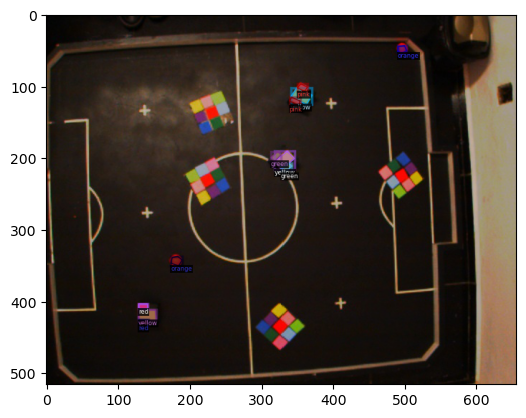

In [5]:
dataset_dicts = get_data(train_dir)
train_metadata = MetadataCatalog.get("train")
test_metadata = MetadataCatalog.get("test")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[..., ::-1][..., ::-1])

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cuda"
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("test")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 3
cfg.INPUT.RANDOM_FLIP = "horizontal"
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 300
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.SOLVER.STEPS = []   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes) 


In [7]:
def mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    # can use other ways to read image
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    # See "Data Augmentation" tutorial for details usage
    auginput = T.AugInput(image)
    transform = T.RandomLighting(0.6)(auginput)
    image = torch.from_numpy(auginput.image.transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
       "image": image,
       "instances": utils.annotations_to_instances(annos, image.shape[1:])
    }


In [8]:
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper)


In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/03 10:28:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[12/03 10:28:10 d2.engine.train_loop]: Starting training from iteration 0


/home/samcbk/anaconda3/envs/ct213/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/03 10:28:22 d2.utils.events]:  eta: 0:02:26  iter: 19  total_loss: 3.229  loss_cls: 1.706  loss_box_reg: 0.3953  loss_mask: 0.6908  loss_rpn_cls: 0.1695  loss_rpn_loc: 0.2852  time: 0.5148  data_time: 0.0088  lr: 0.00016068  max_mem: 3306M
[12/03 10:28:32 d2.utils.events]:  eta: 0:02:16  iter: 39  total_loss: 2.268  loss_cls: 0.722  loss_box_reg: 0.6443  loss_mask: 0.6401  loss_rpn_cls: 0.07622  loss_rpn_loc: 0.1949  time: 0.5221  data_time: 0.0034  lr: 0.00032718  max_mem: 3384M
[12/03 10:28:44 d2.utils.events]:  eta: 0:02:10  iter: 59  total_loss: 2.179  loss_cls: 0.6379  loss_box_reg: 0.7912  loss_mask: 0.5507  loss_rpn_cls: 0.02408  loss_rpn_loc: 0.155  time: 0.5351  data_time: 0.0036  lr: 0.00049367  max_mem: 3479M
[12/03 10:28:55 d2.utils.events]:  eta: 0:02:01  iter: 79  total_loss: 1.929  loss_cls: 0.5116  loss_box_reg: 0.7606  loss_mask: 0.4537  loss_rpn_cls: 0.01068  loss_rpn_loc: 0.1557  time: 0.5443  data_time: 0.0034  lr: 0.00066017  max_mem: 3479M
[12/03 10:29:07 d2.u

KeyError: "Dataset 't' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, cityscapes_fine_panoptic_train, cityscapes_fine_panoptic_val, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val, ade20k_sem_seg_train, ade20k_sem_seg_val, train, val, test"

# Visualize Augmentation

In [10]:
train_data_loader = trainer.build_train_loader(cfg)
data_iter = iter(train_data_loader)
batch = next(data_iter)

[12/03 10:31:08 d2.data.build]: Removed 0 images with no usable annotations. 40 images left.
[12/03 10:31:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[12/03 10:31:08 d2.data.build]: Using training sampler TrainingSampler
[12/03 10:31:08 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[12/03 10:31:08 d2.data.common]: Serializing 40 elements to byte tensors and concatenating them all ...
[12/03 10:31:08 d2.data.common]: Serialized dataset takes 0.09 MiB


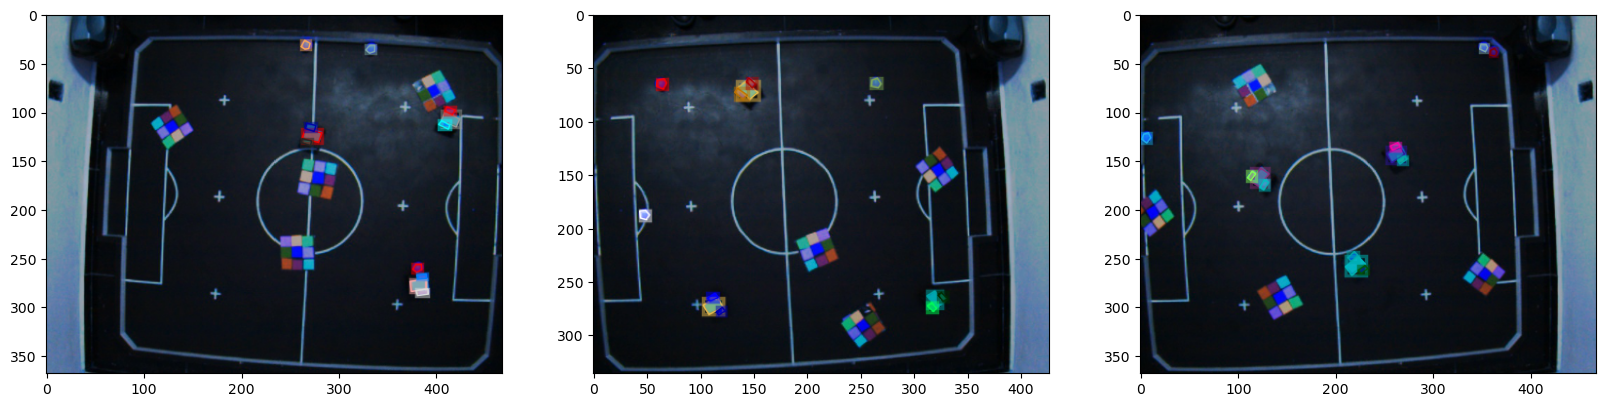

In [11]:
rows, cols = 3, 3
plt.figure(figsize=(20,20))

for i, per_image in enumerate(batch[:int(rows*cols)]):
    
    plt.subplot(rows, cols, i+1)
    
    # Pytorch tensor is in (C, H, W) format
    img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
    img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

    visualizer = Visualizer(img, metadata=train_metadata, scale=0.5)

    target_fields = per_image["instances"].get_fields()
    labels = None
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    plt.imshow(vis.get_image()[:, :, ::-1])

# Test Model

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)

[12/03 10:31:12 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [13]:
i = 0
for d in [file for file in os.listdir(test_dir) if not file.endswith('.json')]:    
    im = cv2.imread(test_dir +"/"+ d)
    outputs = predictor(im) 
    v = Visualizer(im[:, :, ::-1])
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite("test_" + str(i) + ".jpg", out.get_image()[..., ::-1])
    i += 1

In [14]:
i = 0
for d in os.listdir(val_dir):    
    im = cv2.imread(val_dir + "/" + d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1])
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite("val_" + str(i) + ".jpg", out.get_image()[..., ::-1])
    i += 1

In [15]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Launching TensorBoard...

KeyboardInterrupt: 

: 

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)